### Import Essential Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Data preprocessing settings
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Splitting the training dataset into training and validation sets
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Setting up DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Defining the model


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # Number of classes in CIFAR10
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


###optimizer

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


### Model training

In [5]:
num_epochs = 16
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    val_losses.append(running_loss / len(val_loader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')


Epoch 1, Train Loss: 1.5514, Validation Loss: 1.3163
Epoch 2, Train Loss: 1.1815, Validation Loss: 1.1665
Epoch 3, Train Loss: 0.9796, Validation Loss: 1.0554
Epoch 4, Train Loss: 0.8164, Validation Loss: 1.0562
Epoch 5, Train Loss: 0.6587, Validation Loss: 0.9054
Epoch 6, Train Loss: 0.5206, Validation Loss: 0.8052
Epoch 7, Train Loss: 0.3996, Validation Loss: 0.8805
Epoch 8, Train Loss: 0.3120, Validation Loss: 0.7050
Epoch 9, Train Loss: 0.2494, Validation Loss: 0.6053
Epoch 10, Train Loss: 0.2153, Validation Loss: 0.5000
Epoch 11, Train Loss: 0.1888, Validation Loss: 0.5551
Epoch 12, Train Loss: 0.1658, Validation Loss: 0.4085
Epoch 13, Train Loss: 0.1537, Validation Loss: 0.3362
Epoch 14, Train Loss: 0.1376, Validation Loss: 0.2445
Epoch 15, Train Loss: 0.1333, Validation Loss: 0.2804
Epoch 16, Train Loss: 0.1197, Validation Loss: 0.3605


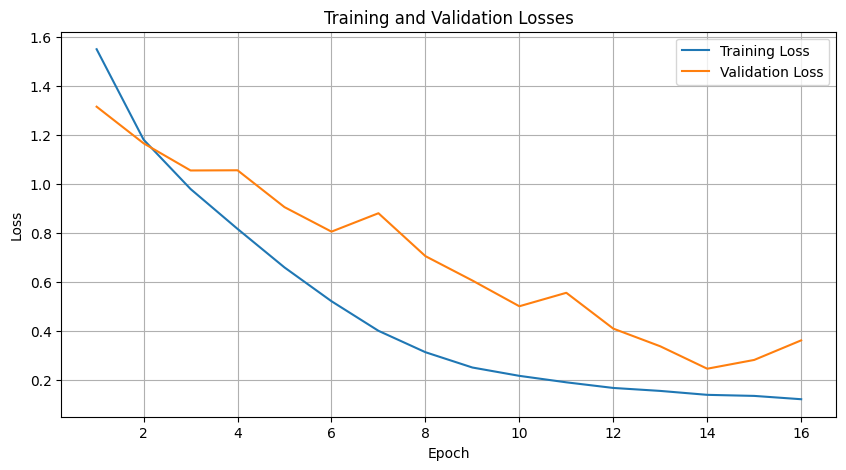

In [6]:
# Defining training epochs
epochs = range(1, len(train_losses) + 1)

# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
! pip install umap-learn


In [ ]:
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor = feature_extractor.to(device)

In [ ]:
def extract_features(dataloader):
    features = []
    labels = []

    feature_extractor.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, lbls = data[0].to(device), data[1].to(device)
            output = feature_extractor(inputs)
            features.extend(output.view(output.size(0), -1).cpu().numpy())
            labels.extend(lbls.cpu().numpy())

    return np.array(features), np.array(labels)

# Extracting features
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)


### UMAP for Train data

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


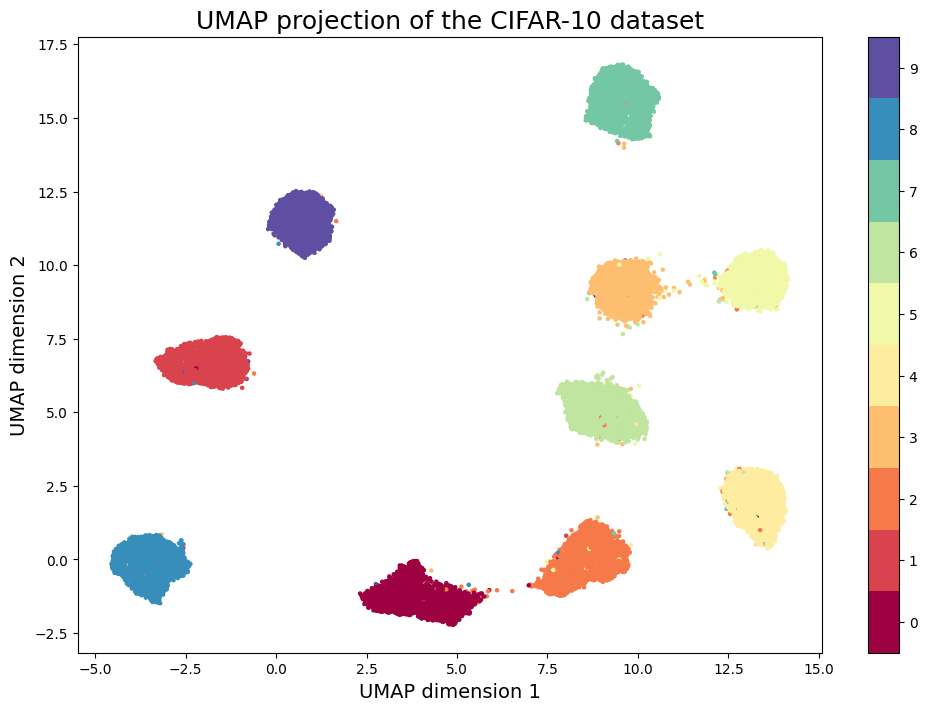

In [ ]:
import umap
# Using UMAP to reduce the dimensionality of features to two dimensions
reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(train_features)

# Visualizing the results
plt.figure(figsize=(12, 8))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=train_labels, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the CIFAR-10 dataset', fontsize=18)
plt.xlabel('UMAP dimension 1', fontsize=14)
plt.ylabel('UMAP dimension 2', fontsize=14)
plt.show()


### Evaluating the model on the test data


In [10]:
model.eval()

correct = 0
total = 0
test_loss = 0.0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')


Test Loss: 0.0494, Test Accuracy: 69.91%


### UMAP for Test Data

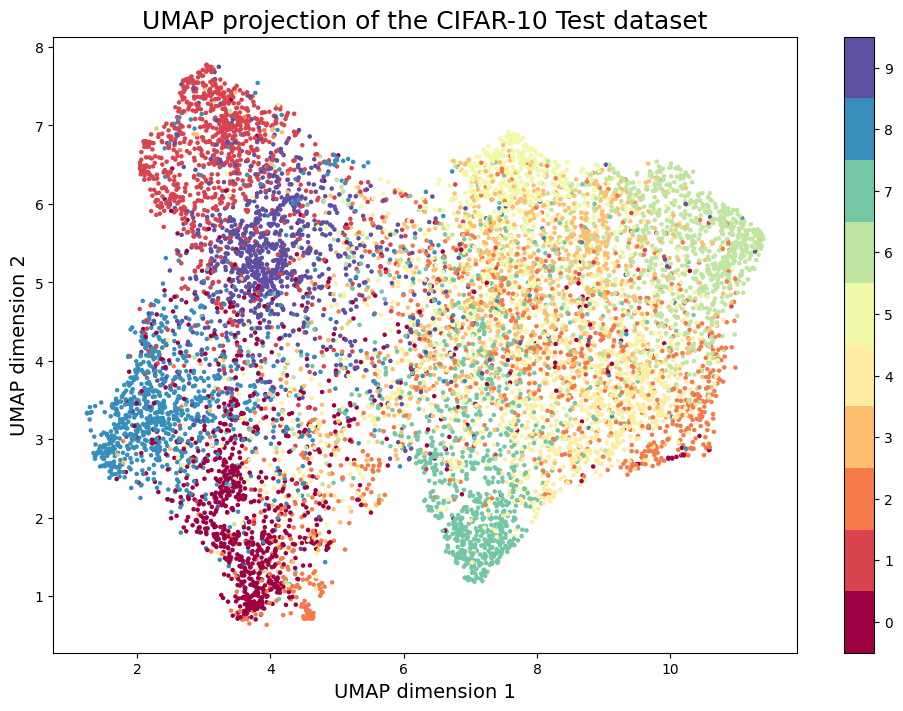

In [ ]:
# Extracting features for test data
test_features, test_labels = extract_features(test_loader)

# Using UMAP to reduce the dimensionality of features to two dimensions for test data
umap_embedding_test = reducer.fit_transform(test_features)

# Visualizing the results for test data
plt.figure(figsize=(12, 8))
plt.scatter(umap_embedding_test[:, 0], umap_embedding_test[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the CIFAR-10 Test dataset', fontsize=18)
plt.xlabel('UMAP dimension 1', fontsize=14)
plt.ylabel('UMAP dimension 2', fontsize=14)
plt.show()


### Function for adding random noise to an image


In [12]:
def add_random_noise(image, noise_level=0.01):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image


### Function for generating adversarial examples using FGSM


In [13]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


###Evaluating the model on adversarial data

In [19]:
criterion = torch.nn.CrossEntropyLoss()

# FGSM Attack
epsilon = 0.001  # A value for FGSM attack
adv_examples = []  # List to store adversarial examples

correct = 0
total = 0
adv_test_loss = 0.0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    # Prediction and backward process
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Generating FGSM noise and adding to the image
    perturbed_data = fgsm_attack(images, epsilon, images.grad)
    adv_examples.append(perturbed_data)

    # Evaluating the model with adversarial images
    outputs_adv = model(perturbed_data)
    adv_test_loss += criterion(outputs_adv, labels).item()

    _, predicted = torch.max(outputs_adv.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Calculating loss and accuracy
adv_test_loss /= len(test_loader.dataset)
accuracy = correct / total
print(f'Adversarial Test Loss: {adv_test_loss:.4f}, Adversarial Test Accuracy: {accuracy * 100.0:.2f}%')


Adversarial Test Loss: 0.1325, Adversarial Test Accuracy: 48.41%


In [20]:
adv_features = []
adv_labels = []

model.eval()
for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True
    # Using the model to compute outputs and extracting gradients for FGSM
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbed_images = fgsm_attack(images, epsilon, images.grad)

    # Using the model to extract features
    features = model(perturbed_images)
    adv_features.append(features.detach().cpu().numpy())
    adv_labels.append(labels.cpu().numpy())

# Converting lists to numpy arrays for use in UMAP
adv_features_np = np.concatenate(adv_features, axis=0)
adv_labels_np = np.concatenate(adv_labels, axis=0)


### UMAP for Adversarial Data

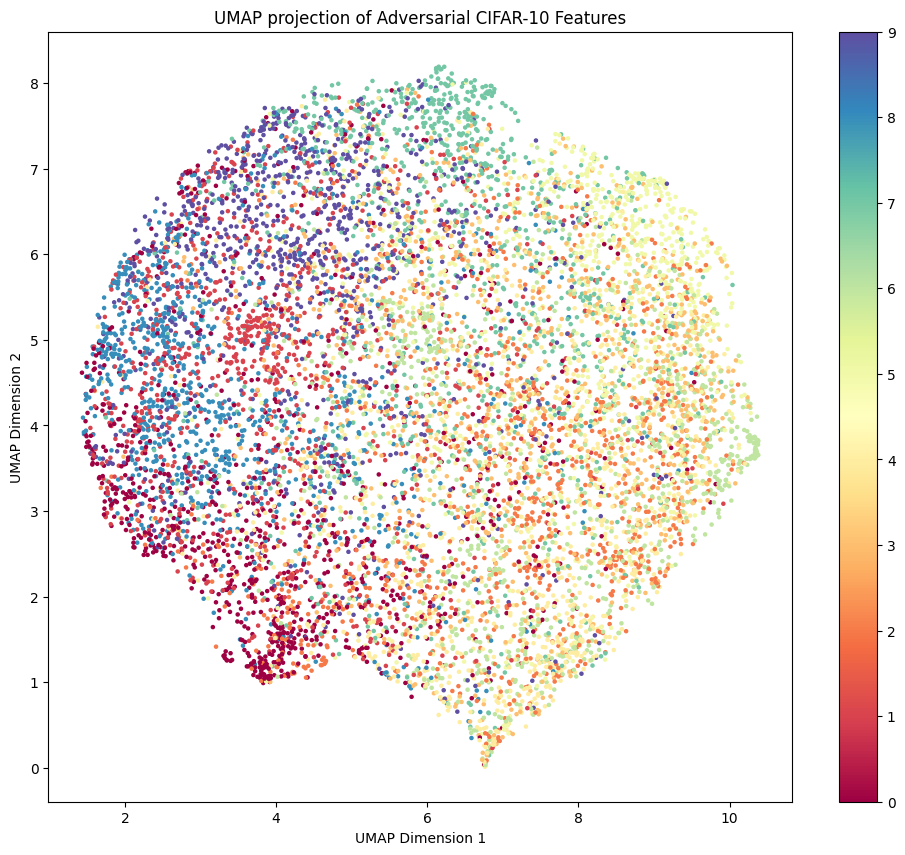

In [ ]:
import umap
reducer = umap.UMAP()
adv_umap_embedding = reducer.fit_transform(adv_features_np)

# Plotting
plt.figure(figsize=(12,10))
plt.scatter(adv_umap_embedding[:, 0], adv_umap_embedding[:, 1], c=adv_labels_np, cmap='Spectral', s=5)
plt.colorbar()
plt.title('UMAP projection of Adversarial CIFAR-10 Features')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


### Showing adversaril images with noise

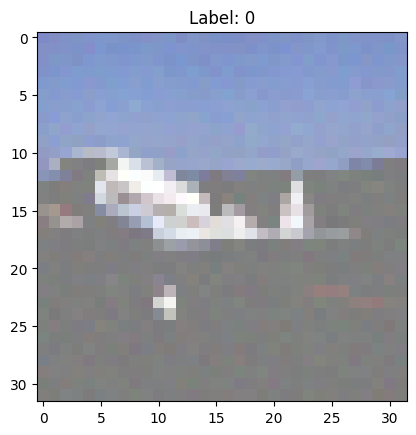

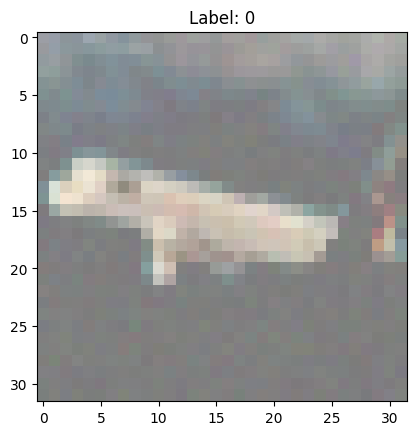

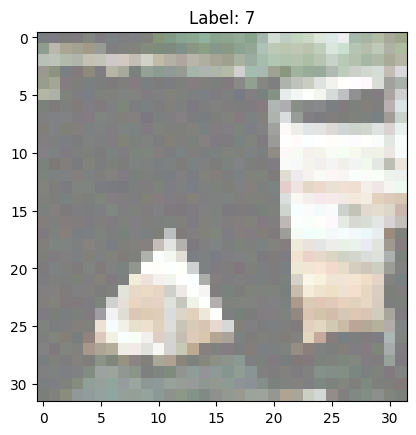

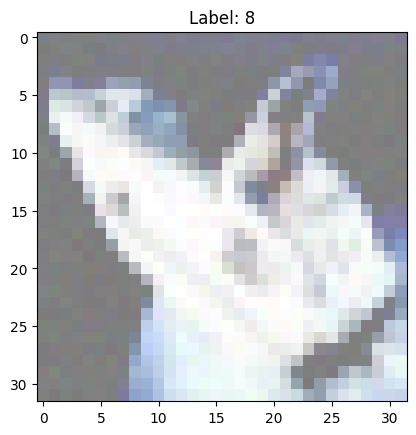

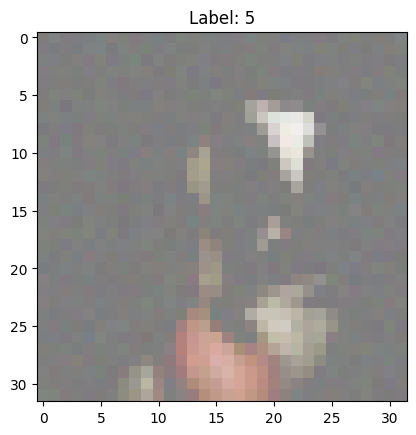

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# A function to unnormalize images
def unnormalize(img):
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    img = img.clone().detach()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    return img

# A function to display images
def imshow(img, label, add_noise_flag=False):
    img = unnormalize(img)  # unnormalize the image
    if add_noise_flag:
        img = add_random_noise(img)  # Adding noise if the flag is active
    img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'Label: {label}')
    plt.show()

def show_adversarial_images(perturbed_data, labels, indices, add_noise_flag=False):
    for idx in indices:
        image, label = perturbed_data[idx], labels[idx]
        imshow(image, label, add_noise_flag)

show_adversarial_images(perturbed_data, labels, indices, add_noise_flag=True)
